In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.theta import ThetaModel
from scipy.optimize import fsolve
from scipy.special import rel_entr, kl_div
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [2]:
sunspot_ts = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/sunspot.year.csv')
sunspot_ts.index = sunspot_ts['time'].values
sunspot_ts.drop(['Unnamed: 0', 'time'], axis=1, inplace=True)
sunspot_ts.rename({'value': 'sunspot.year'}, axis=1, inplace=True)

In [3]:
wage = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/monthly-wage.csv', sep=';', index_col= 0, parse_dates=True)
wage_ts = wage.astype(int)

In [4]:
energy_df = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/energy_consumption.csv',
                        sep=',', parse_dates=['Date'], dayfirst=False, index_col='Date')

energy_df = energy_df[energy_df.id == 2]
energy_df = energy_df['2010-01-01':'2015-05-13']
energy_df.dropna(axis=1, inplace=True)

energy_ts = energy_df.EnergyConsumption.astype(int)

In [5]:
wage_ts

,Real wage
Month,
1993-01-01,100
1993-02-01,99
1993-03-01,101
1993-04-01,110
1993-05-01,115
...,...
2016-09-01,224
2016-10-01,223
2016-11-01,225


In [6]:
(max(energy_ts) - min(energy_ts)) / 330

599.2727272727273

In [7]:
np.quantile(abs(energy_ts - energy_ts.shift(1))[1:], 0.05)

330.80000000000007

In [8]:
def get_density_forecast(ts, horizon, base_alg, base_params={}, bins='auto', omega=None, fittedvalues=False):
    """
    Returns a list of density dictionaries {'bins': np.array, 'probs': np.array, 'dotted_forecast': float}.
    
    Parameters
    ----------
    ts : array_like
        The time series to model.
    horizon : int
        The horizon to forecast.
    base_alg : {ExponentialSmoothing, SimpleExpSmoothing, Holt}
        The name of base algoritm for making density forecast.
    base_params : dict
        A Dictionary with base algorithm parameters.
    bins: int or sequence of scalars or str, optional
        Define how to calculate bins.
    fittedvalues: bool
        Include fitted values in density dictionaries or not.
    """
    
    # my experiment 
    if omega:
        min_bound = omega[0]
        max_bound = omega[-1]
        bins = np.linspace(min_bound, max_bound, bins + 1)
        
    
    alg = base_alg(ts, **base_params).fit()
    
    if fittedvalues:
        alg_preds = alg.predict(start=0, end=len(ts) + horizon - 1)
        density_dicts = [{'bins': [], 'probs': [], 'dotted_forecast': None} for _ in range(len(ts) + horizon)]
    else:
        alg_preds = alg.predict(start=len(ts), end=len(ts) + horizon - 1)
        density_dicts = [{'bins': [], 'probs': [], 'dotted_forecast': None} for _ in range(horizon)]
    
    for i in range(len(alg_preds)):
        density_dicts[i]['dotted_forecast'] = alg_preds[i]
        
        current_density = alg.resid + alg_preds[i]
        density_dicts[i]['probs'], density_dicts[i]['bins'] = np.histogram(current_density, bins=bins, density=True)
    
    return density_dicts

In [9]:
def plot_density_forecast(ts, delay, base_alg, ax=None, **kwargs):
        
    density_dict = get_density_forecast(ts, delay, base_alg, **kwargs)[delay - 1]

    left_edges = density_dict['bins'][:-1]

    colors = []
    for i in range(len(left_edges) - 1):
        if left_edges[i] < density_dict['dotted_forecast'] < left_edges[i+1]:
            colors.append('coral')
        else:
            colors.append('royalblue')
    
    alg_name = str(base_alg)[str(base_alg).find('model.') + 6:-2]
    
    if ax:
        ax.bar(left_edges, density_dict['probs'], align='edge',
               width=0.9*(left_edges[1] - left_edges[0]), color=colors)
        ax.set_title(f'{alg_name}: density forecast with delay={delay}')
    else:
        plt.bar(left_edges, density_dict['probs'], align='edge',
               width=0.9*(left_edges[1] - left_edges[0]), color=colors)
        plt.title(f'{alg_name}: density forecast with delay={delay}')

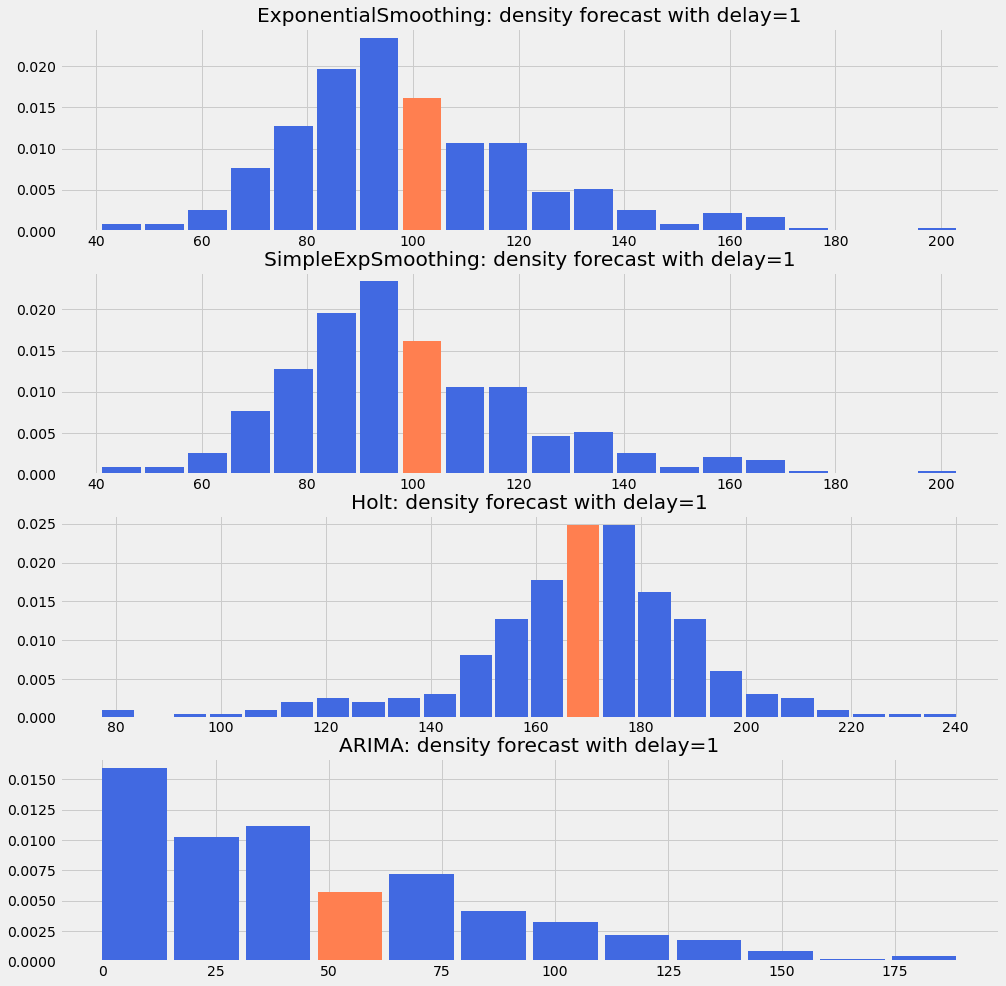

In [10]:
fig, ax = plt.subplots(4, figsize=(15,16))

for i, alg in enumerate([ExponentialSmoothing, SimpleExpSmoothing, Holt, ARIMA]):
    plot_density_forecast(sunspot_ts.values, 1, alg, ax=ax[i], bins='auto')

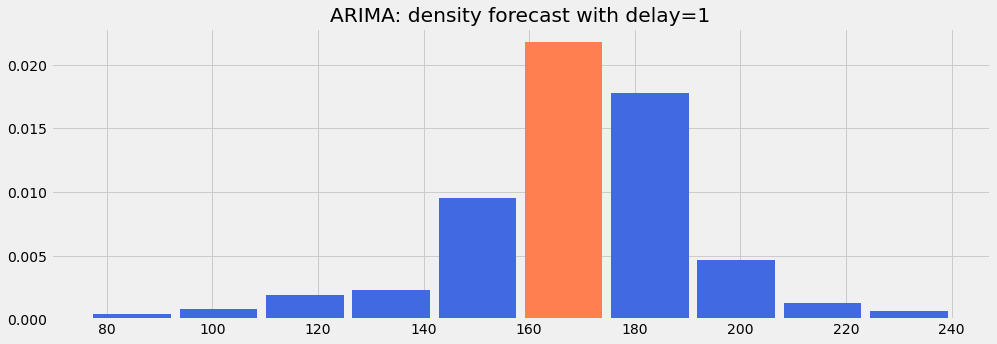

In [11]:
plt.figure(figsize=(15,5))
plot_density_forecast(sunspot_ts.values, 1, ARIMA, base_params={'order': (1, 2, 0)}, bins=10)

In [12]:
def get_omega(ts):
#     # my experiment 
#     min_w = (preds[0]['bins'][0] + preds[0]['bins'][1]) / 2
#     max_w = (preds[0]['bins'][-2] + preds[0]['bins'][-1]) / 2
    
    min_o = int(np.floor(min(ts)))
    max_o = int(np.ceil(max(ts)))
    return list(range(min_o, max_o + 1))

In [13]:
def brier_loss(y_true, density_dict):
    """
    Returns np.array of brier scores.
    
    Parameters
    ----------
    y_true : float
        A true value.
    density_dict : dict
        Dict with bins and probabilities information.
    """
    bins_number = density_dict['probs'].size
    bins_true = [0] * bins_number

    for i in range(bins_number):
        if density_dict['bins'][i] <= y_true <= density_dict['bins'][i + 1]:
            bins_true[i] = 1
            break
    
#     brier_loss = np.sum(((np.diff(density_dict['bins']) * density_dict['probs']) - bins_true)**2)
#     brier_loss = np.sum((density_dict['probs'] - bins_true / np.diff(density_dict['bins']))**2)
    brier_loss = np.sum((density_dict['probs'] - bins_true)**2)
    
    if np.sum(bins_true) == 0:
        brier_loss += 1 # / np.diff(density_dict['bins']).mean()
        
    return brier_loss

In [14]:
def brier_loss2(y_true, density_dict):
    bins_number = density_dict['probs'].size
    bins_true = [0] * bins_number

    for i in range(bins_number):
        if density_dict['bins'][i] <= y_true <= density_dict['bins'][i + 1]:
            bins_true[i] = 1
            break
    
    brier_loss = np.sum(((np.diff(density_dict['bins']) * density_dict['probs']) - bins_true)**2)
    
    if np.sum(bins_true) == 0:
        brier_loss += 1
        
    return brier_loss

In [15]:
def brier_loss3(y_true, density_dict):
    bins_number = density_dict['probs'].size
    bins_true = [0] * bins_number

    for i in range(bins_number):
        if density_dict['bins'][i] <= y_true <= density_dict['bins'][i + 1]:
            bins_true[i] = 1
            break
    
    brier_loss = np.sum((density_dict['probs'] - bins_true / np.diff(density_dict['bins']))**2)
    
    if np.sum(bins_true) == 0:
        brier_loss += 1 / np.diff(density_dict['bins']).mean()
        
    return brier_loss

In [16]:
def get_generalized_loss(y_true, density_dicts, loss_function):
    """
    Returns np.array of brier scores.
    
    Parameters
    ----------
    y_true : float
        A true value.
    density_dicts : dict or array-like of dicts
        Dicts with bins and probabilities information.
    """
    if type(density_dicts) == dict:
        density_dicts = [density_dicts]
    
    losses = [np.nan] * len(density_dicts)
    
    for density_dict_count, density_dict in enumerate(density_dicts):
        losses[density_dict_count] = loss_function(y_true, density_dict)
        
    return np.array(losses)

In [17]:
def avoid_overflowing(base, power_array):
    maximum = np.max(power_array)
    minimum = np.min(power_array)
    
    pmax = -np.log(base)/np.log(2) * maximum
    pmin = -np.log(base)/np.log(2) * minimum
    
    if np.abs(pmax-pmin) > 2097:
        print('Overflow is imminent. Further calculations are not advised')
        return base ** power_array
    power_shift = abs((51+pmin+pmax)/2)
    power_shift = power_shift + min(0, pmin - power_shift + 1023)
    
    power_array = power_array - np.abs(power_shift * np.log(2) / np.log(base))
    
    return base ** power_array

In [18]:
def get_generalized_prediction(ts, preds, omega, weights, loss_function, eta=1):
    generalized_predictions = []
    
    for w in omega:
        losses = get_generalized_loss(w, preds, loss_function)
        exp_losses = avoid_overflowing(np.e, -eta * losses)
        generalized_predictions.append(-(1 / eta) * np.log(np.sum(weights * exp_losses)))
        
    return np.array(generalized_predictions)

In [19]:
from scipy.optimize import fsolve

def s_equation(s, generalized_predictions, m=2):
    return np.sum([max(x,0) for x in s - generalized_predictions]) - m

In [20]:
def substitution_function(generalized_predictions, s, m=2):
    predictions = [max(x,0) / m for x in s - generalized_predictions]
    return predictions

In [21]:
def get_AA_density(omega_and_predictions, bins):
    probs = [0] * (len(bins) - 1)
    for i in range(len(bins) - 1):
        for omega, pred in omega_and_predictions:
            if bins[i] <= omega < bins[i + 1]:
                probs[i] += pred
    return np.array(probs) / np.array(np.diff(bins))

In [22]:
def update_weights(weights, losses, eta=1):
    exp_losses = avoid_overflowing(np.e, -eta * np.array(losses))
    new_weights = weights * exp_losses
    return new_weights / (np.sum(new_weights))

In [23]:
def aggregating_algorithm(ts, horizon, base_alg_dict, bins=10, loss_function=brier_loss, weights=None, eta=1):
    """
    Returns density dictionary {'bins': np.array, 'probs': np.array, 'dotted_forecast': float}.
    
    Parameters
    ----------
    ts : array_like
        The time series to model.
    delay : int
        The delay to forecast.
    base_alg_dict : dict
        The dictionary with the names of base algoritms and their params:
        base_alg {ExponentialSmoothing, SimpleExpSmoothing, Holt} - name of base algorithm.
        base_alg_params : dict - a dictionary of base algorithm's parameters.
    loss_function : function
        The loss function of aggregating algorithm.
    """
    T = len(ts)
    K = len(base_alg_dict)
    
    AA_preds = [{} for i in range(T + horizon)]
    BA_preds = np.array([{} for i in range((T + horizon) * K)]).reshape(K, T + horizon) 
    
    if not weights:
        weights = np.full(K, 1/K)
    
    omega = get_omega(ts) # здесь в Omega прогнозы не учитываются
    
    i = 0
    for base_alg, base_alg_params in base_alg_dict.items():
        BA_preds[i] = get_density_forecast(ts, horizon, base_alg, base_params=base_alg_params,
                                           bins=bins, omega=omega, fittedvalues=True)
        i += 1
        
    losses, prev_losses = None, None
        
    for t in tqdm(range(T + horizon)):
        preds = BA_preds[:, t]
        
        if not prev_losses:     
            prev_losses = [loss_function(ts[t], pred) for pred in preds]  # cheat
              
        generalized_predictions = get_generalized_prediction(ts[:t], preds, omega,
                                                             weights, loss_function, eta)
        
        #solving the equation to find s
        s_init = np.max(generalized_predictions)
        s = fsolve(s_equation, s_init, args=generalized_predictions)
        
        #get real prediction with substitution function
        AA_preds[t]['bins'] = BA_preds[:, t][0]['bins']
        real_predictions = substitution_function(generalized_predictions, s)
        omega_and_predictions = list(zip(omega, real_predictions))
        AA_preds[t]['probs'] = get_AA_density(omega_and_predictions, AA_preds[t]['bins'])
        
        #update weights 
        if t < T:
            losses = [loss_function(ts[t], pred) for pred in preds]
            weights = update_weights(weights, losses, eta)

            prev_losses = losses
    
    return AA_preds

**Анализ результатов (AA vs Base Algorithms, AA vs Theoretical Boundary of Loss function)**

In [24]:
omega = get_omega(sunspot_ts.values)

Holt_preds = get_density_forecast(sunspot_ts.values, 3, Holt,
                                  bins=10, omega=omega, fittedvalues=True)
SES_preds = get_density_forecast(sunspot_ts.values, 3, SimpleExpSmoothing,
                                 bins=10, omega=omega, fittedvalues=True)

AA_preds = aggregating_algorithm(sunspot_ts.values, 3, {Holt: {}, SimpleExpSmoothing: {}}, bins=10)
AA_preds2 = aggregating_algorithm(sunspot_ts.values, 3, {Holt: {}, SimpleExpSmoothing: {}},
                                   bins=10, loss_function=brier_loss2)
AA_preds3 = aggregating_algorithm(sunspot_ts.values, 3, {Holt: {}, SimpleExpSmoothing: {}},
                                   bins=10, loss_function=brier_loss3)

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

In [25]:
Holt_losses = []
SES_losses = []
AA_losses = []
for i in range(len(sunspot_ts.values)):
    Holt_losses.append(brier_loss(sunspot_ts.values[i], Holt_preds[i]))
    SES_losses.append((brier_loss(sunspot_ts.values[i], SES_preds[i])))
    AA_losses.append((brier_loss(sunspot_ts.values[i], AA_preds[i])))

theor_bound = np.minimum(Holt_losses, SES_losses) + np.full_like(sunspot_ts.index, np.log(2), dtype=float)

Holt_losses2 = []
SES_losses2 = []
AA_losses2 = []
for i in range(len(sunspot_ts.values)):
    Holt_losses2.append(brier_loss2(sunspot_ts.values[i], Holt_preds[i]))
    SES_losses2.append((brier_loss2(sunspot_ts.values[i], SES_preds[i])))
    AA_losses2.append((brier_loss2(sunspot_ts.values[i], AA_preds2[i])))

Holt_losses3 = []
SES_losses3 = []
AA_losses3 = []
for i in range(len(sunspot_ts.values)):
    Holt_losses3.append(brier_loss3(sunspot_ts.values[i], Holt_preds[i]))
    SES_losses3.append((brier_loss3(sunspot_ts.values[i], SES_preds[i])))
    AA_losses3.append((brier_loss3(sunspot_ts.values[i], AA_preds3[i])))

Average Holt Loss: 0.9611774192732604
Average SES Loss: 0.9682709048467827
Average AA Loss: 0.9547724897266034


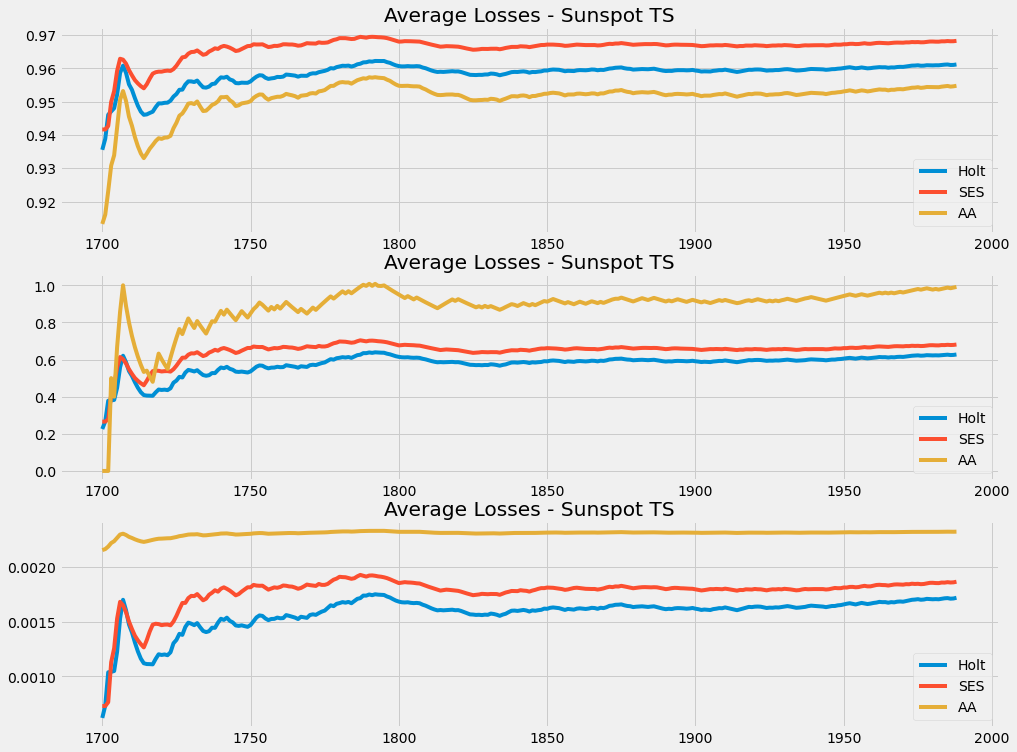

In [26]:
fig, ax = plt.subplots(3, figsize=(15,12))

ax[0].plot(sunspot_ts.index, np.cumsum(Holt_losses) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].plot(sunspot_ts.index, np.cumsum(SES_losses) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].plot(sunspot_ts.index, np.cumsum(AA_losses) / list(range(1, len(sunspot_ts.values) + 1)))
ax[0].set_title('Average Losses - Sunspot TS')
ax[0].legend(['Holt', 'SES', 'AA'], loc='lower right');

ax[1].plot(sunspot_ts.index, np.cumsum(Holt_losses2) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].plot(sunspot_ts.index, np.cumsum(SES_losses2) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].plot(sunspot_ts.index, np.cumsum(AA_losses2) / list(range(1, len(sunspot_ts.values) + 1)))
ax[1].set_title('Average Losses - Sunspot TS')
ax[1].legend(['Holt', 'SES', 'AA'], loc='lower right');

ax[2].plot(sunspot_ts.index, np.cumsum(Holt_losses3) / list(range(1, len(sunspot_ts.values) + 1)))
ax[2].plot(sunspot_ts.index, np.cumsum(SES_losses3) / list(range(1, len(sunspot_ts.values) + 1)))
ax[2].plot(sunspot_ts.index, np.cumsum(AA_losses3) / list(range(1, len(sunspot_ts.values) + 1)))
ax[2].set_title('Average Losses - Sunspot TS')
ax[2].legend(['Holt', 'SES', 'AA'], loc='lower right');

print(f'Average Holt Loss: {np.mean(Holt_losses)}')
print(f'Average SES Loss: {np.mean(SES_losses)}')
print(f'Average AA Loss: {np.mean(AA_losses)}')

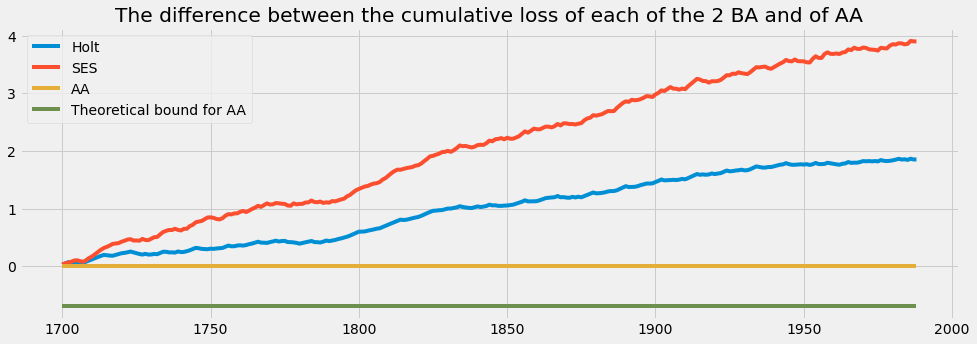

In [27]:
plt.figure(figsize=(15, 5))
plt.plot(sunspot_ts.index, np.cumsum(Holt_losses) - np.cumsum(AA_losses))
plt.plot(sunspot_ts.index, np.cumsum(SES_losses) - np.cumsum(AA_losses))
plt.plot(sunspot_ts.index, np.cumsum(AA_losses) - np.cumsum(AA_losses))
plt.plot(sunspot_ts.index, -np.full_like(sunspot_ts.index, np.log(2), dtype=float))

plt.title('The diﬀerence between the cumulative loss of each of the 2 BA and of AA')
plt.legend(['Holt', 'SES', 'AA', 'Theoretical bound for AA'], loc='upper left');

In [28]:
omega = get_omega(wage_ts.values)

Holt_preds = get_density_forecast(wage_ts.values, 3, Holt,
                                  bins=10, omega=omega, fittedvalues=True)
SES_preds = get_density_forecast(wage_ts.values, 3, SimpleExpSmoothing,
                                 bins=10, omega=omega, fittedvalues=True)

AA_preds = aggregating_algorithm(wage_ts.values, 3, {Holt: {}, SimpleExpSmoothing: {}}, bins=10)

Holt_losses = []
SES_losses = []
AA_losses = []
for i in range(len(wage_ts.values)):
    Holt_losses.append(brier_loss(wage_ts.values[i], Holt_preds[i]))
    SES_losses.append((brier_loss(wage_ts.values[i], SES_preds[i])))
    AA_losses.append((brier_loss(wage_ts.values[i], AA_preds[i])))

theor_bound = np.minimum(Holt_losses, SES_losses) + np.full_like(wage_ts.index, np.log(2), dtype=float)

  0%|          | 0/292 [00:00<?, ?it/s]

Average Holt Loss: 0.9569211051904591
Average SES Loss: 0.9553159024288972
Average AA Loss: 0.948110552855029


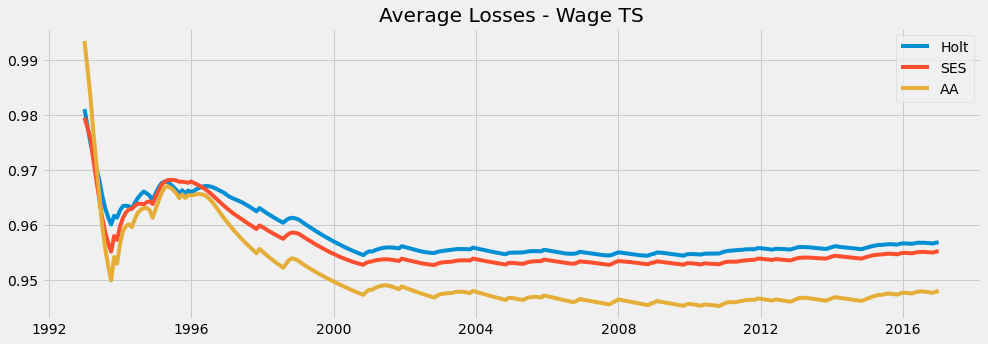

In [29]:
plt.figure(figsize=(15, 5))
plt.plot(wage_ts.index, np.cumsum(Holt_losses) / list(range(1, len(wage_ts.values) + 1)))
plt.plot(wage_ts.index, np.cumsum(SES_losses) / list(range(1, len(wage_ts.values) + 1)))
plt.plot(wage_ts.index, np.cumsum(AA_losses) / list(range(1, len(wage_ts.values) + 1)))
plt.title('Average Losses - Wage TS')
plt.legend(['Holt', 'SES', 'AA'], loc='upper right');

print(f'Average Holt Loss: {np.mean(Holt_losses)}')
print(f'Average SES Loss: {np.mean(SES_losses)}')
print(f'Average AA Loss: {np.mean(AA_losses)}')

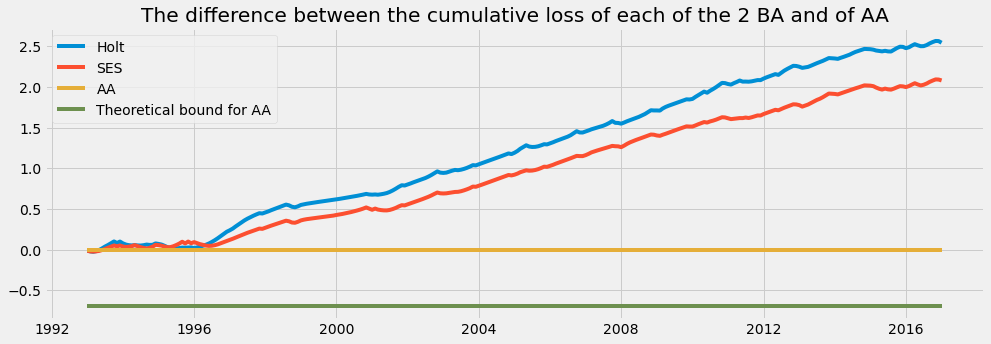

In [30]:
plt.figure(figsize=(15, 5))
plt.plot(wage_ts.index, np.cumsum(Holt_losses) - np.cumsum(AA_losses))
plt.plot(wage_ts.index, np.cumsum(SES_losses) - np.cumsum(AA_losses))
plt.plot(wage_ts.index, np.cumsum(AA_losses) - np.cumsum(AA_losses))
plt.plot(wage_ts.index, -np.full_like(sunspot_ts.index, np.log(2), dtype=float))

plt.title('The diﬀerence between the cumulative loss of each of the 2 BA and of AA')
plt.legend(['Holt', 'SES', 'AA', 'Theoretical bound for AA'], loc='upper left');

**Зависимость абсолютной величины brier loss от количества бинов**

In [32]:
losses_dict = {}
losses_dict2 = {}
losses_dict3 = {}

for bins in tqdm(range(1, 31)):
    preds = aggregating_algorithm(sunspot_ts.values, 3, {Holt: {}, SimpleExpSmoothing: {}}, bins=bins)
    preds2 = aggregating_algorithm(sunspot_ts.values, 3, {Holt: {}, SimpleExpSmoothing: {}},
                                   bins=bins, loss_function=brier_loss2)
    preds3 = aggregating_algorithm(sunspot_ts.values, 3, {Holt: {}, SimpleExpSmoothing: {}},
                                   bins=bins, loss_function=brier_loss3)
    
    loss = 0
    loss2 = 0
    loss3 = 0
    for i in range(len(sunspot_ts.values)):
        loss += brier_loss(sunspot_ts.values[i], preds[i])
        loss2 += brier_loss2(sunspot_ts.values[i], preds2[i])
        loss3 += brier_loss3(sunspot_ts.values[i], preds3[i])
        
    losses_dict[bins] = loss / len(sunspot_ts.values)
    losses_dict2[bins] = loss2 / len(sunspot_ts.values)
    losses_dict3[bins] = loss3 / len(sunspot_ts.values)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

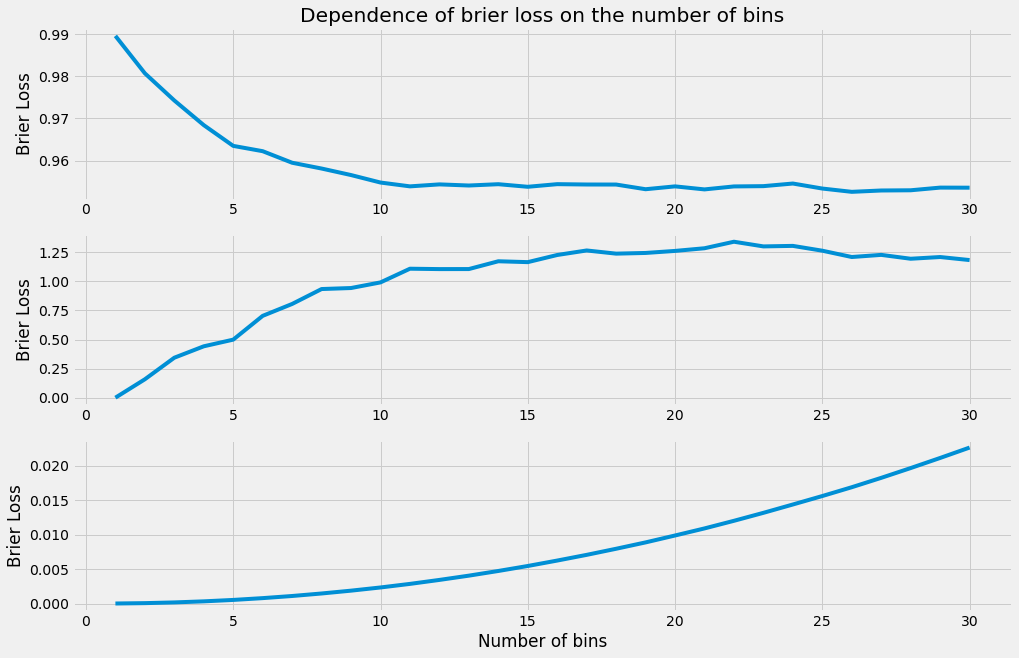

In [33]:
fig, ax = plt.subplots(3, figsize=(15,10))

ax[0].plot(losses_dict.keys(), losses_dict.values())
ax[0].set_title('Dependence of brier loss on the number of bins')
ax[0].set_ylabel('Brier Loss')

ax[1].plot(losses_dict2.keys(), losses_dict2.values())
ax[1].set_ylabel('Brier Loss')

ax[2].plot(losses_dict3.keys(), losses_dict3.values())
ax[2].set_ylabel('Brier Loss')
ax[2].set_xlabel('Number of bins');

In [34]:
# plt.figure(figsize=(15,4))
# plt.plot(losses_dict.keys(), losses_dict.values())
# plt.title('Dependence of brier loss on the number of bins');
# plt.xlabel('Number of bins')
# plt.ylabel('Brier Loss');

**Реализовать гистограммные метрики точности прогноза**

Kullback-Leibler divergence

In [35]:
AA_preds[0]['bins']

array([ 48. ,  74.8, 101.6, 128.4, 155.2, 182. , 208.8, 235.6, 262.4,
       289.2, 316. ])

In [36]:
from scipy.special import rel_entr, kl_div

In [37]:
rel_entr(AA_preds[0]['probs'], AA_preds[1]['probs'])

array([ 0.        , -0.00317371,  0.00534786,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [38]:
rel_entr(np.histogram(wage_ts.values, bins=10, density=True)[0], AA_preds[-1]['probs'])

array([        inf,         inf,         inf,         inf,         inf,
               inf, -0.00349619, -0.00686394,         inf,         inf])

Sharpness (Negative Log-likelihood)

In [39]:
# def NLL(density_dict, omega=None, base=np.e):
#     probs = (np.roll(density_dict['bins'], -1) - density_dict['bins'])[:-1] * density_dict['probs']
    
#     if omega:
#         for x in omega:
#     else:
#         nll = -np.log(probs) / np.log(base)
# #         nll = np.where(nll==np.inf, 0, nll) 
    
#     return nll

In [40]:
np.diff(AA_preds[10]['bins']) * (AA_preds[10]['probs'])

array([0.        , 0.05753706, 0.94246294, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

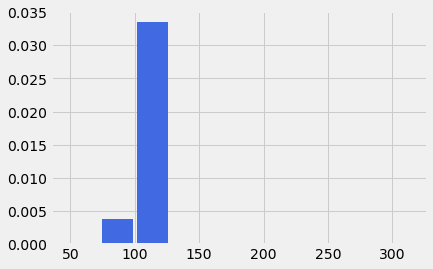

In [41]:
left_edges = AA_preds[0]['bins'][:-1]

plt.bar(left_edges, AA_preds[0]['probs'], align='edge',
        width=0.9*(left_edges[1] - left_edges[0]), color='royalblue');

In [ ]:
# T = sunspot_ts.size
# ts = sunspot_ts.values
# delay = 3
# K = 2

# omega = get_omega(ts)

# BA_preds = np.array([{}]*(T + delay)*K).reshape(K, T + delay) 

# i = 0
# for base_alg, base_alg_params in {Holt: {}, SimpleExpSmoothing: {}}.items():
#     BA_preds[i] = get_density_forecast(ts, delay, base_alg, base_params=base_alg_params,
#                                        bins=10, omega=omega, fittedvalues=True)
#     i += 1

In [ ]:
# np.sum(np.diff(BA_preds[:, 0][0]['bins']) * BA_preds[:, 0][0]['probs'])

In [ ]:
# losses = [brier_loss(20, pred) for pred in BA_preds[:, 0]]
# weights = np.full(2, 1/2)
# losses, weights

In [ ]:
# losses = [brier_loss(20, pred) for pred in BA_preds[:, 0]]
# weights = np.full(2, 1/2)
# losses, weights

# generalized_predictions = get_generalized_prediction(ts, BA_preds[:, 0], omega,
#                                                      weights, brier_loss, eta=1)
# generalized_predictions

In [ ]:
# s_init = np.max(generalized_predictions)
# s = fsolve(s_equation, s_init, args=generalized_predictions)
# s

In [ ]:
# omega_and_pred = list(zip(omega, substitution_function(generalized_predictions, s)))

# get_AA_density(omega_and_pred, BA_preds[:, 0][0]['bins'])

In [ ]:
# np.sum(np.diff(BA_preds[:, 0][0]['bins']) * np.array(get_AA_density(omega_and_pred, BA_preds[:, 0][0]['bins'])))